## Многорукие бандиты


<img src="https://miro.medium.com/max/1146/1*XU13pI_KETfwIJnc8gWS7w.png">
Названия метода пошло от «одноруких бандитов» — игровых автоматов в казино с рычагом, за который можно потянуть и получить выигрыш. Представьте, что вы находитесь в зале с десятком таких автоматов, и у вас есть N бесплатных попыток для игры на любом из них. Вы, конечно же, хотите выиграть побольше денег, но заранее не знаете, какой автомат дает самый большой выигрыш. Проблема многоруких бандитов как раз заключается в том, чтобы найти самый выгодный автомат с минимальными потерями

In [63]:
import gym
import numpy as np
from gym.utils import seeding
from gym.vector.utils import spaces
import matplotlib.pyplot as plt


class BanditEnv(gym.Env):
    """
    Bandit environment base to allow agents to interact with the class n-armed bandit
    in different variations
    p_dist:
        A list of probabilities of the likelihood that a particular bandit will pay out
    r_dist:
        A list of either rewards (if number) or means and standard deviations (if list)
        of the payout that bandit has
    info:
        Info about the environment that the agents is not supposed to know. For instance,
        info can releal the index of the optimal arm, or the value of prior parameter.
        Can be useful to evaluate the agent's perfomance
    """

    def __init__(self, p_dist, r_dist, info={}):
        if len(p_dist) != len(r_dist):
            raise ValueError("Probability and Reward distribution must be the same length")

        if min(p_dist) < 0 or max(p_dist) > 1:
            raise ValueError("All probabilities must be between 0 and 1")

        for reward in r_dist:
            if isinstance(reward, list) and reward[1] <= 0:
                raise ValueError("Standard deviation in rewards must all be greater than 0")

        self.p_dist = p_dist
        self.r_dist = r_dist

        self.info = info

        self.n_bandits = len(p_dist)
        self.action_space = spaces.Discrete(self.n_bandits)
        self.observation_space = spaces.Box(-1.0, 1.0, (1,))  #
        self.np_random = None
        self.seed()
        self.q_star = max([x[0] for x in self.r_dist])

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)

        reward = 0
        done = True

        if np.random.uniform() < self.p_dist[action]:
            if not isinstance(self.r_dist[action], list):
                reward = self.r_dist[action]
            else:
                reward = np.random.normal(self.r_dist[action][0], self.r_dist[action][1])

        info = {"regret": self.q_star - self.r_dist[action][0]}
        return [0], reward, done, info  #

    def reset(self):
        return [0]  #

    def render(self, mode='human', close=False):
        pass


class BanditTenArmedGaussian(BanditEnv):
    """
    10 armed bandit mentioned on page 30 of Sutton and Barto's
    [Reinforcement Learning: An Introduction](https://www.dropbox.com/s/b3psxv2r0ccmf80/book2015oct.pdf?dl=0)
    Actions always pay out
    Mean of payout is pulled from a normal distribution (0, 1) (called q*(a))
    Actual reward is drawn from a normal distribution (q*(a), 1)
    """

    def __init__(self, bandits=10):
        p_dist = np.full(bandits, 1)
        r_dist = []

        for i in range(bandits):
            r_dist.append([np.random.normal(0, 1), 1])

        BanditEnv.__init__(self, p_dist=p_dist, r_dist=r_dist)

In [64]:
env = BanditTenArmedGaussian()

num_steps = 10000
q, r = 0, 0
for _ in range(num_steps):
    _, reward, _, info = env.step(env.action_space.sample())
    q += info['regret']
    r += reward
    
print(q / num_steps, r / num_steps)

    

1.8328699870196774 -0.02238525472642386


## Крактое напоминание теории:

Оптимальная полезность $V^*$: $$V^* = Q(a^*) = \max_{a \in A} Q(a)$$.

Regret (потери) - упущенное на каждом шаге вознаграждение: $$l_t=\mathbb{E}(V^*-Q(a_t)$$

Обновление полезностей:
$$Q_t(a) = Q_{t-1} + \frac{1}{N_t(a_t)}(r_t - Q_{t-1})$$

Алгоритм Upper Confidence Bound (UCB):
$$a_t=\textit{arg}\max_{a \in A}(Q(a) + \sqrt{\frac{c \log{t}}{N_t(a)}}$$ 

### Задание 1: Реализуйте алгоритмы: $\epsilon-greedy$, $\epsilon-greedy$ с затуханием и UCB. 

In [117]:
from abc import ABC, abstractmethod
from scipy.special import softmax
np.random.seed(42)
class Strategy(ABC):
    def __init__(self, n_arms, epsilon):
        self.Q = np.zeros(n_arms) #средние награды за каждое действие
        self.n = np.ones(n_arms)
        self.epsilon = epsilon
        self.inital_epsilon = epsilon
        self.n_arms = n_arms
    
    @abstractmethod
    def make_action(self):
        pass
    
    def update(self, action, reward):
        self.n[action] += 1
        self.Q[action] += reward
        
    def reset(self):
        self.__init__(self.n_arms, self.inital_epsilon)

class RandomСhoiceStrategy(Strategy):

    def make_action(self):
        return np.random.randint(self.n_arms)

class EpsilonGreedyStrategy(Strategy):
    
    def make_action(self):
        if np.random.random() > self.epsilon:
            return np.argmax(self.Q)
        return np.random.randint(self.n_arms)

class UcbStrategy(Strategy):
    def __init__(self, n_arms, c):
        super().__init__(n_arms, 0)
        self.c = c
        
    def reset(self):
        self.__init__(self.n_arms, self.c)
    
    def make_action(self):
        T = self.n.sum()
        u = np.sqrt(self.c * np.log(T) / self.n)
        action = (self.Q/self.n + u).argmax()
        return action
    
class EpsilonGreedyFadeStrategy(Strategy):
    def __init__(self, n_arms, epsilon, epsilon_rate):
        super().__init__(n_arms, epsilon)
        self.epsilon_rate = epsilon_rate
    def reset(self):
        self.__init__(self.n_arms, self.inital_epsilon, self.epsilon_rate)
    def make_action(self):
        self.epsilon = self.epsilon * self.epsilon_rate
        if np.random.random() > self.epsilon:
            return np.argmax(self.Q)
        return np.random.randint(self.n_arms)        


class SoftMaxStrategy(Strategy):
    #def __init__(self, n_arms, epsilon):
    #    super().__init__(n_arms, epsilon)
    def make_action(self):
        probs = softmax(self.Q/self.n_arms)
        action = np.random.choice(self.n_arms, p=probs)
        return action

def test(n_trials, env, agent):
    regrets = [0]
    r = 0
    for _ in range(n_trials):
        action = agent.make_action()
        _, reward, _, info = env.step(action)
        agent.update(action, reward)
        r += info['regret']

        regrets.append(r)
    return regrets



### Задание 2: Нарисуйте кривые потерь (regret) для каждого из алгоритмов. (подсказка: используйте wandb).

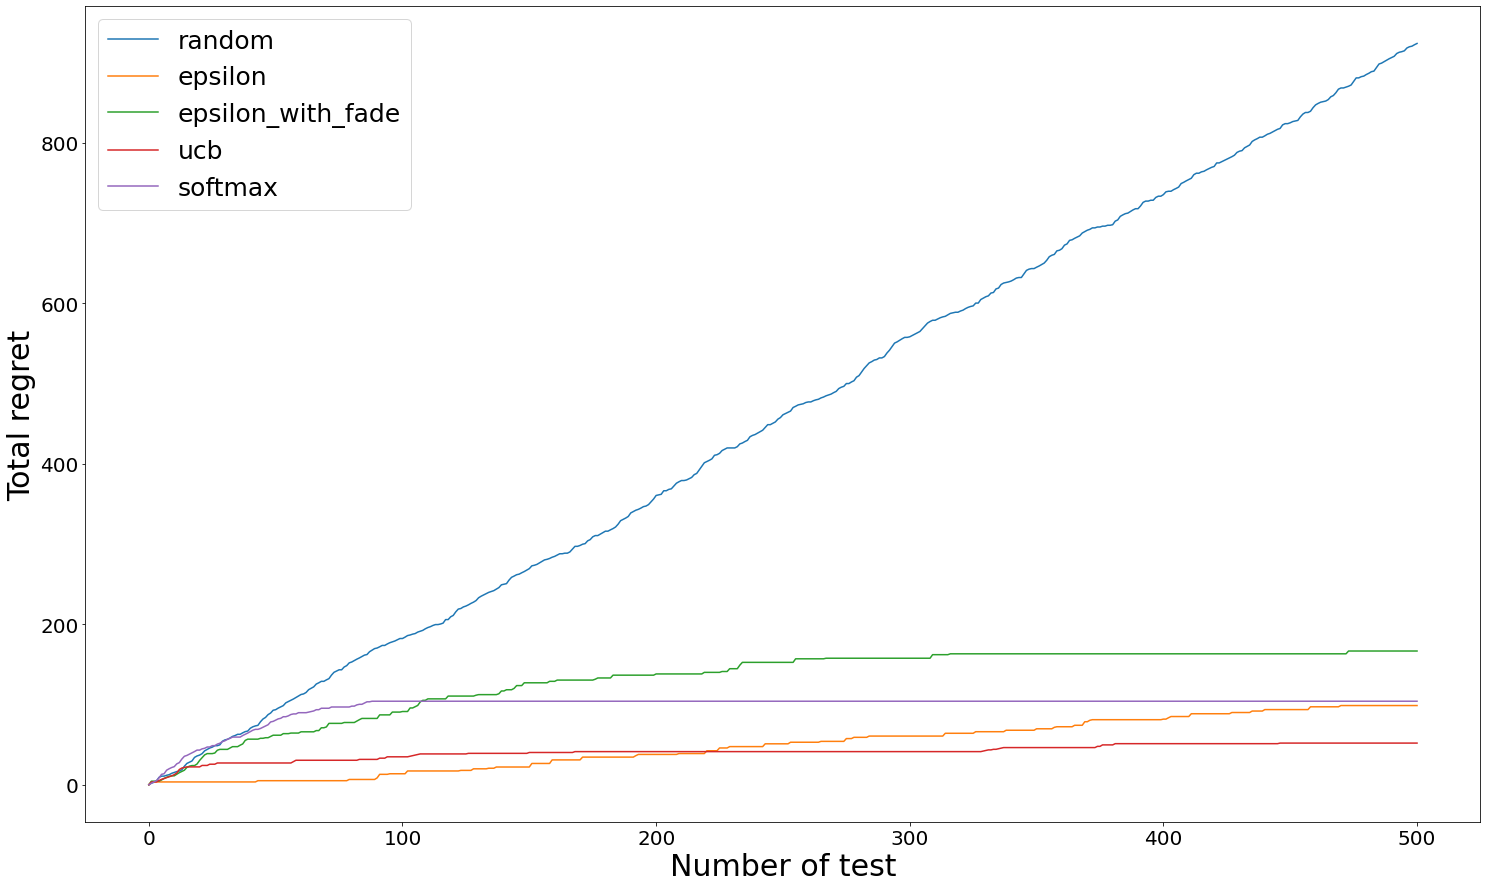

In [118]:
n_t = 500
xs = np.arange(n_t+1)

random = RandomСhoiceStrategy(10, 1)
epsilong = EpsilonGreedyStrategy(10, 0.1)
epsilonadaptive = EpsilonGreedyFadeStrategy(10, 0.95, 0.99)
ucb = UcbStrategy(10, 2.)
sm = SoftMaxStrategy(10, 1)

strategies = [random, epsilong, epsilonadaptive, ucb, sm]


for st in strategies:
    reg_stat = test(n_t, env, st)
    plt.plot(xs, reg_stat)
plt.legend(['random', 'epsilon', 'epsilon_with_fade', 'ucb', 'softmax'], fontsize=25)
plt.xlabel("Number of test", size=30)
plt.ylabel('Total regret', size=30)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('save.png')

## Контекстные бандиты (Online Contextual Bandits)

### 1. Описание задачи

Контекстные бандиты служат для решения проблемы, аналогичной многоруким бандитам, с той лишь разницей, что на каждой итерации выбора действия есть дополнительная информация.
 
Задача может быть описана итеративным процессом получения данных:

* На каждой итерации среда генерирует наблюдение, которое состоит из вектора признаков фиксированного размера, и значение вознаграждения, который является стохастичным, но зависит от первого вектора. 

* Агент должен выбрать одно действие из множества действий ("рук") $m$.

* Среда сообщает вознаграждение для руки, которую выбрал агент.

Цель - построить стратегию, которая будет максимизировать вознаграждение, получаемое агентом.

Примерами сценариев использования могут быть задачи онлайн рекомендаций, в которых есть лишь информация о том, нажал ли пользователь на рекламную ссылку или нет, а информации про другие ссылки, на которые он нажал - нет.

Или задачи клинических испытаний, в которых мы знаем, как человек отреагировал на одно лекарство, но не знаем, как он отреагировал бы на другое.

### 2. Алгоритмы

В данном пункте мы частично рассмотрим библиотеку [Contextual Bandits](https://github.com/david-cortes/contextualbandits)

Библиотека предлагает реализации большого списка алгоритмов:

* Upper-confidence bounds: `BootstrappedUCB`, `LogisticUCB`, и `LinUCB`.

* Thompson sampling: `BootstrappedTS`, `LogisticTS`, `LinTS`, and `SoftmaxExplorer`. 

* Greedy exploration: `EpsilonGreedy`

* Adaptive exploration: `AdaptiveGreedy`

Более полную информацию вы можете найти в [документации](https://contextual-bandits.readthedocs.io/en/latest/).
Также, обратите внимание на [примеры](https://github.com/david-cortes/contextualbandits/tree/master/example).


## 3. Задание 

Вашей задачей является применение контекстных бандитов для **выбранного вами** датасета и сравнение на графике нескольких алгоритмов, представленной библиотеки. Предлагается воспользоваться заготовками кода ниже.
В проект должны входить:
1. Описание датасета
2. Описание препроцессинга данных
3. Сравнение алгоритмов
4. Ваши выводы по результатам экспериментов
5. Код/тетрадка, для воспроизведения результатов

### Устанавливаем библиотеку и скачиваем данные

В данном случае используется датасет [Bibtex dataset](http://mlkd.csd.auth.gr/publication_details.asp?publicationID=278)  (см. _"Multilabel text classification for automated tag suggestion"_), содержащие теги, которые люди присвоили разным документам (цель - научиться предлагать теги на основе данных из этих документов). Скачать датасет можно на сайте: [Extreme Classification Repository](http://manikvarma.org/downloads/XC/XMLRepository.html).

In [ ]:
!pip install contextualbandits

In [52]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=0B3lPMIHmG6vGcy1xM2pJZ09MMGM' -O bib.zip

--2023-06-12 12:31:51--  https://docs.google.com/uc?export=download&id=0B3lPMIHmG6vGcy1xM2pJZ09MMGM
Распознаётся docs.google.com (docs.google.com)… 64.233.162.194
Подключение к docs.google.com (docs.google.com)|64.233.162.194|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 303 See Other
Адрес: https://doc-0k-a0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/40ufumilm6cpabnmbh5ac68qq9vqn6a9/1686562275000/17883253590272791010/*/0B3lPMIHmG6vGcy1xM2pJZ09MMGM?e=download&uuid=99a3b594-76be-4e58-9814-6c89d1c0bee8 [переход]
Предупреждение: в HTTP маски не поддерживаются.
--2023-06-12 12:31:54--  https://doc-0k-a0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/40ufumilm6cpabnmbh5ac68qq9vqn6a9/1686562275000/17883253590272791010/*/0B3lPMIHmG6vGcy1xM2pJZ09MMGM?e=download&uuid=99a3b594-76be-4e58-9814-6c89d1c0bee8
Распознаётся doc-0k-a0-docs.googleusercontent.com (doc-0k-a0-docs.googleusercontent.com)… 108.177.14.132
Подкл

In [53]:
!unzip bib.zip

Archive:  bib.zip
  inflating: Bibtex/Bibtex_data.txt  
  inflating: Bibtex/bibtex_trSplit.txt  
  inflating: Bibtex/bibtex_tstSplit.txt  


### Считываем данные

Данные представляют собой текстовый файл, используемый в libsvm и других системах, но с первой строкой, указывающей количество строк, столбцов и классов:

In [85]:
import pandas as pd, numpy as np, re
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

def parse_data(filename):
    with open(filename, "rb") as f:
        infoline = f.readline()
        infoline = re.sub(r"^b'", "", str(infoline))
        n_features = int(re.sub(r"^\d+\s(\d+)\s\d+.*$", r"\1", infoline))
        features, labels = load_svmlight_file(f, n_features=n_features, multilabel=True)
    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(labels)
    features = np.array(features.todense())
    features = np.ascontiguousarray(features)
    return features, labels

X, y = parse_data("Mediamill/Mediamill_data.txt")
print(X.shape)
print(y.shape)

    #print(text, "\r\n")  # "[1,2,3,4,5]"
#print(text.split())
    #print(train_lst)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1111)
X_train.shape
y_train.shape

(43907, 120)
(43907, 101)


(30734, 101)

## Пакетные модели

Логистическая регрессия и контекстный бандит:

In [86]:
from sklearn.linear_model import LogisticRegression

from contextualbandits.online import BootstrappedUCB, BootstrappedTS, LogisticUCB, \
            SeparateClassifiers, EpsilonGreedy, AdaptiveGreedy, ExploreFirst, \
            ActiveExplorer, SoftmaxExplorer, LogisticTS
from copy import deepcopy

nchoices = y.shape[1]
base_algorithm = LogisticRegression(solver='lbfgs',max_iter=1000, warm_start=True)
beta_prior = ((3./nchoices, 4), 2) # until there are at least 2 observations of each class, will use this prior
beta_prior_ucb = ((5./nchoices, 4), 2) # UCB gives higher numbers, thus the higher positive prior
beta_prior_ts = ((2./np.log2(nchoices), 4), 2)


## The base algorithm is embedded in different metaheuristics
bootstrapped_ucb = BootstrappedUCB(deepcopy(base_algorithm), nchoices = nchoices,
                                   beta_prior = beta_prior_ucb, percentile = 80,
                                   random_state = 1111)

epsilonGreedy = EpsilonGreedy(deepcopy(base_algorithm), beta_prior = beta_prior_ucb, 
                              nchoices=nchoices, explore_prob=0.99, decay=0.95, random_state = 1111)
bootstrapped_ts = BootstrappedTS(deepcopy(base_algorithm), nchoices=nchoices, beta_prior = beta_prior_ucb, random_state = 1111)

log_ts = LogisticTS(nchoices=nchoices, lambda_=0.2, random_state = 1111, beta_prior = beta_prior_ucb)

separate_class= SeparateClassifiers(deepcopy(base_algorithm), nchoices=nchoices, beta_prior = beta_prior_ucb, random_state=1111)

models = [bootstrapped_ucb, epsilonGreedy, bootstrapped_ts, log_ts, separate_class]

/Users/vampire/miniforge3/lib/python3.9/site-packages/contextualbandits/online.py:1494: UserWarning: Warning: 'EpsilonGreedy' has a very high decay rate.
  warnings.warn("Warning: 'EpsilonGreedy' has a very high decay rate.")


In [120]:
# These lists will keep track of the rewards obtained by each policy
rewards_ucb, rewards_eps, rewards_ts, rewards_logts, rewards_sep, *_ = [list() for i in range(len(models))]

lst_rewards = [rewards_ucb, rewards_eps, rewards_ts, rewards_logts, rewards_sep]

# batch size - algorithms will be refit after N rounds
batch_size = 50

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X_train[:batch_size, :]
np.random.seed(1)
action_chosen = np.random.randint(nchoices, size=batch_size)
#print(np.arange(batch_size), action_chosen)
rewards_received = y_train[np.arange(batch_size), action_chosen]
#print(y)
# fitting models for the first time
for model in models:
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)
    
# these lists will keep track of which actions does each policy choose
lst_a_ucb, lst_greedy, lst_ts, lst_log_ts, lst_sep, *_ = [action_chosen.copy() for i in range(len(models))]

lst_actions = [lst_a_ucb, lst_greedy, lst_ts, lst_log_ts, lst_sep]

# rounds are simulated from the full dataset
def simulate_rounds(model, rewards, actions_hist, X_global, y_global, batch_st, batch_end):
    np.random.seed(batch_st)
    
    ## choosing actions for this batch
    actions_this_batch = model.predict(X_global[batch_st:batch_end, :]).astype('uint8')
    
    # keeping track of the sum of rewards received
    rewards.append(y_global[np.arange(batch_st, batch_end), actions_this_batch].sum())
    
    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    
    # now refitting the algorithms after observing these new rewards
    np.random.seed(batch_st)
    model.fit(X_global[:batch_end, :], new_actions_hist, y_global[np.arange(batch_end), new_actions_hist],)
              #warm_start = True)
    
    return new_actions_hist



# now running all the simulation
for i in range(int(np.floor(X_train.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X_train.shape[0]])
    
    for model in range(len(models)):
        lst_actions[model] = simulate_rounds(models[model],
                                             lst_rewards[model],
                                             lst_actions[model],
                                             X_train, y_train,
                                             batch_st, batch_end)

### Визуализируем результаты

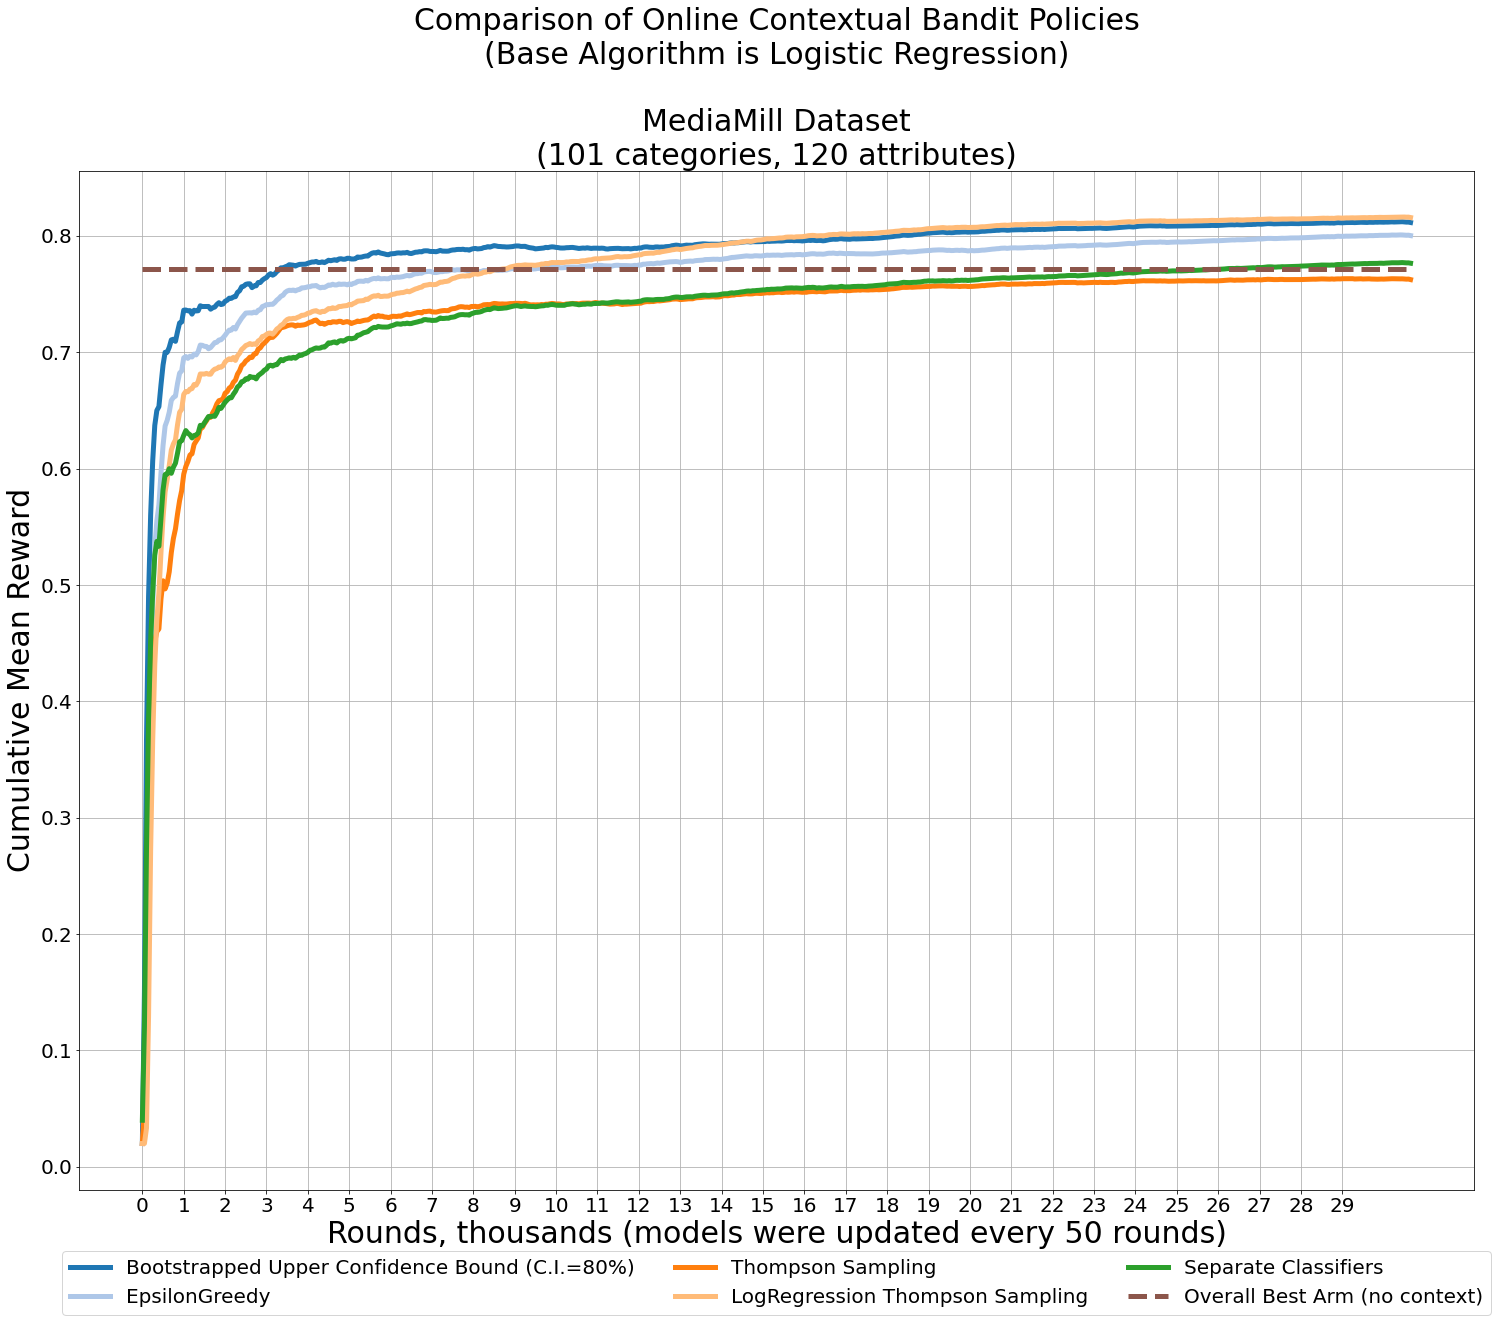

In [121]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_ucb), label="Bootstrapped Upper Confidence Bound (C.I.=80%)",linewidth=lwd,color=colors[0])
plt.plot(get_mean_reward(rewards_eps), label="EpsilonGreedy",linewidth=lwd,color=colors[1])
plt.plot(get_mean_reward(rewards_ts), label="Thompson Sampling",linewidth=lwd,color=colors[2])
plt.plot(get_mean_reward(rewards_logts), label="LogRegression Thompson Sampling",linewidth=lwd,color=colors[3])
plt.plot(get_mean_reward(rewards_sep), label="Separate Classifiers",linewidth=lwd,color=colors[4])
plt.plot(np.repeat(y.mean(axis=0).max(),len(rewards_ucb)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[10],ls='dashed')


# import warnings
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=20)
plt.xticks([i*20 for i in range(30)], [i*1 for i in range(30)])
#plt.xticks([i*20 for i in range(47)])

plt.xlabel('Rounds, thousands (models were updated every 50 rounds)', size=30)
plt.ylabel('Cumulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression)\n\nMediaMill Dataset\n(101 categories, 120 attributes)',size=30)
plt.grid()
plt.savefig('save_train.png')
plt.show()


In [122]:
def evaluate_model(model, rewards, actions_hist, X_global, y_global, batch_st, batch_end):
    actions_this_batch = model.predict(X_global[batch_st:batch_end, :]).astype('uint8')
    rewards.append(y_global[np.arange(batch_st, batch_end), actions_this_batch].sum())
    
rewards_ucb, rewards_eps, rewards_ts, rewards_logts, rewards_sep, *_ = [list() for i in range(len(models))]
lst_rewards = [rewards_ucb, rewards_eps, rewards_ts, rewards_logts, rewards_sep]
batch_size = 50

for i in range(int(np.floor(X_test.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X_test.shape[0]])
    for model in range(len(models)):
        evaluate_model(models[model],
                                             lst_rewards[model],
                                             lst_actions[model],
                                             X_test, y_test,
                                             batch_st, batch_end)

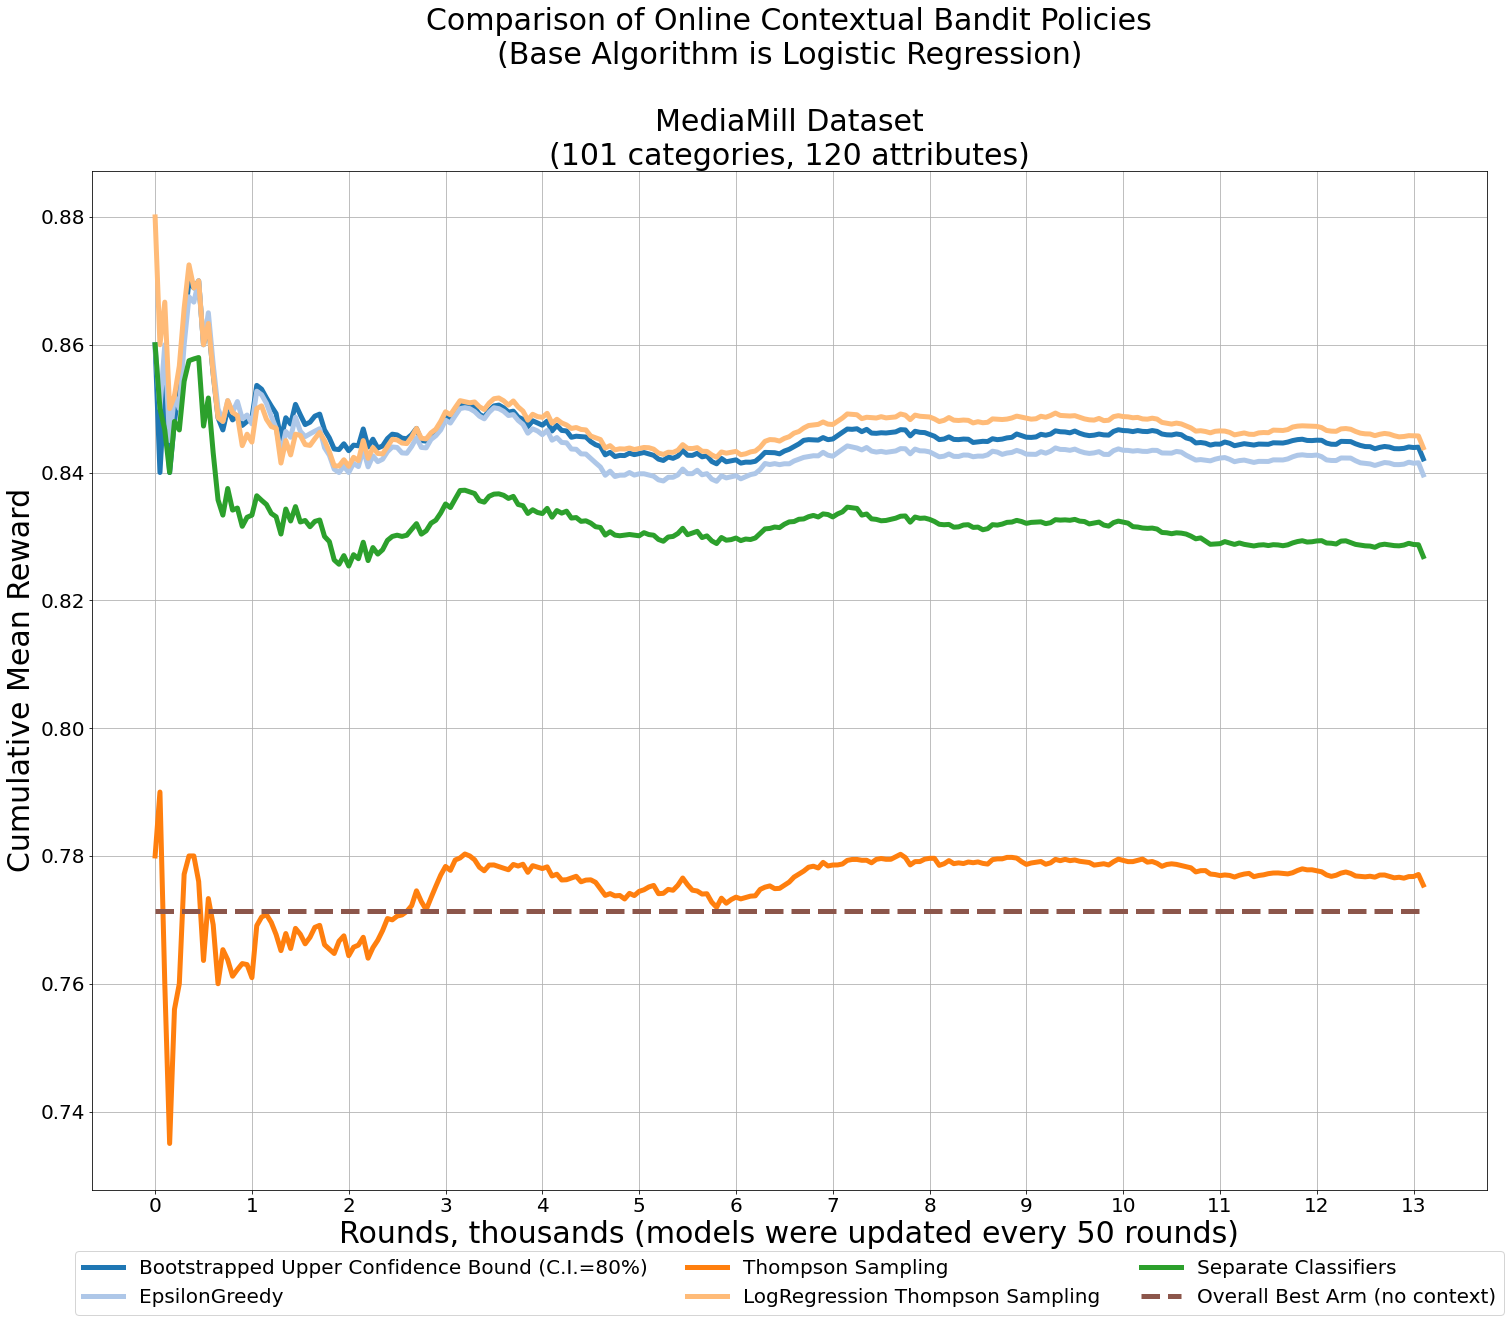

In [125]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew=list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
    return mean_rew

rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_ucb), label="Bootstrapped Upper Confidence Bound (C.I.=80%)",linewidth=lwd,color=colors[0])
plt.plot(get_mean_reward(rewards_eps), label="EpsilonGreedy",linewidth=lwd,color=colors[1])
plt.plot(get_mean_reward(rewards_ts), label="Thompson Sampling",linewidth=lwd,color=colors[2])
plt.plot(get_mean_reward(rewards_logts), label="LogRegression Thompson Sampling",linewidth=lwd,color=colors[3])
plt.plot(get_mean_reward(rewards_sep), label="Separate Classifiers",linewidth=lwd,color=colors[4])
plt.plot(np.repeat(y.mean(axis=0).max(),len(rewards_ucb)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[10],ls='dashed')


# import warnings
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, ncol=3, prop={'size':20})


plt.tick_params(axis='both', which='major', labelsize=20)
plt.xticks([i*20 for i in range(14)], [i*1 for i in range(14)])
#plt.xticks([i*20 for i in range(47)])

plt.xlabel('Rounds, thousands (models were updated every 50 rounds)', size=30)
plt.ylabel('Cumulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression)\n\nMediaMill Dataset\n(101 categories, 120 attributes)',size=30)
plt.grid()
plt.savefig('save_test.png')
plt.show()
